In [103]:
import os
import spacy
import gensim
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

In [104]:
n = 53 # Choose a number for a song to inspect.

In [105]:
def getlistOfTexts(rootdir):
    # input: directory with (subdirectory with) TXT-files to be handled
	# output: list of files lexicographically ordered on path-name

    files_all = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not file.endswith('.txt'):
                continue
            fn = os.path.join(subdir, file)
            files_all.append(fn)

    files_all = sorted(files_all)
    return files_all

liedjeslist = getlistOfTexts('../../data/liedjes')

In [106]:
print(liedjeslist[n])

../../data/liedjes/amsterdam1847-reglement1848/amsterdam1847-reglement1848-01.txt


In [107]:
def texts2list(listOfTexts):
	# input: list of files lexicographically ordered on path-name
    # output: list of texts

	texts = []
	for file in listOfTexts:
		with open(file) as stream:
			text = stream.read()
		texts.append(text)

	return texts

liedjes = texts2list(liedjeslist)

In [108]:
print(liedjes[n])

- I
De mannen
Komt vrienden zingt nu onderling
Ter eer van Kosters vriendenkring
Vereend met onze vrouwen
Dat vrij een ieder ons bespot
Wij smaken nu het reinst genot
Daar kan men op vertrouwen.

De vrouwen
Heb dank o mannen voor deez’ gunst
Wij roemen immers Kosters kunst,
Als weerklank uwer monden
Waarom zijn wij niet even goed
Ook vloeit door ons het Kosters bloed,
Door u aan hem verbonden.

De Mannen
Ja vrouwen daarom zingen wij:
Op ‘t feest staat gij aan onze zij,
Niets kan meer vreugde geven.
Wat stoort ons dan aan onze vreugd,
Wij zullen dan eens regt verheugd
Als Kosters vrienden leven.

Te zamen
Komt zing dan allen blij te moet;
De geest van Koster lacht ons toe
Hij wil den ijer loonen.
Waarmee ‘t erkentlijk nageslacht
Hem eene dankb;re hulde bragt
Met blijde jubeltoonen



In [124]:
def lemmatize(texts):   
    # input: list of texts
    # input: allowed_postags is list of wordtypes to be kept in the lemmatization process
    # output: list of lemmatized texts. Lemmatization by spaCy.

    nlp = spacy.load("nl_core_news_sm") # create spaCy processor named 'nlp' based on small model for Dutch
    nlp.Defaults.stop_words |= {"deez", "zoo", "hoezee", "tra", "la", "li", "eene", "gaan", "komen", "laten", "weer", "vinden"} # optionally: add stopwords to processor

    result = []                                                         
    for text in texts:                                                     

        nlp.max_length = len(text)  
        doc = nlp(text) # tokenize and annotate 'text' with processor named 'nlp'

        new_text = []
        for token in doc: 
            if token.is_alpha: # keep tokens with alphanumerical characters (so no numbers or punctuation)
                if not token.is_stop: # remove stopwords
                    new_text.append(token.lemma_) # get the word in the lemma and add it to the list of words

        final = " ".join(new_text) # transform list of words into a string concatenating all listitems
        result.append(final) # add string to the list of lemmatized texts

    return result

def lemmatize_select(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):   
    # input: list of texts
    # input: allowed_postags is list of wordtypes to be kept in the lemmatization process
    # output: list of lemmatized texts. Lemmatization by spaCy.

    nlp = spacy.load("nl_core_news_sm") # create spaCy processor named 'nlp' based on small model for Dutch
    nlp.Defaults.stop_words |= {"deez", "zoo", "hoezee"} # optionally: add stopwords to processor

    result = []                                                         
    for text in texts:                                                     

        nlp.max_length = len(text)  
        doc = nlp(text) # tokenize and annotate 'text' with processor named 'nlp'

        new_text = []
        for token in doc: 
            if token.is_alpha: # keep tokens with alphanumerical characters (so no numbers or punctuation)
                if not token.is_stop: # remove stopwords
                    if token.pos_ in allowed_postags: # keep wordtypes in the allowed_postags list
                        new_text.append(token.lemma_) # get the word in the lemma and add it to the list of words

        final = " ".join(new_text) # transform list of words into a string concatenating all listitems
        result.append(final) # add string to the list of lemmatized texts

    return result

lemmatized_liedjes = lemmatize(liedjes)


In [125]:

print(lemmatized_liedjes[n])

i man komen vriend zingen onderling eer koster vriendenkring vereend vrouw bespot smaken rein genot vertrouwen vrouw dank o man gunst roemen immers koster kunst weerklank uw monden goed vloeien koster bloed verbinden man vrouw zingen feest staan vreugde storen vreugd reggen verheugd koster vriend leven zamen komen zingen blij geest koster lachen ij loon waarmee erkentlijk nageslacht hulde bragt blijde jubeltoon


In [111]:
def preprocess(texts):
    # input: list of lemmatized texts
    # output: list of lists of preprocessed words, bigrams or trigrams. Preprocessing by gensim.

    # what kind of preprocessing does gensim do?
    result = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        result.append(new)

    # find bigrams and trigrams. Don't understand yet how precisely ... 
    bigram_phrases  = gensim.models.Phrases(result, min_count=5, threshold=100)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[result], threshold=100)
    bigram  = gensim.models.phrases.Phraser(bigram_phrases)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)
    bigrams  = [bigram[doc] for doc in result]
    trigrams = [trigram[bigram[doc]] for doc in result]

    return trigrams

preprocessed_liedjes = preprocess(lemmatized_liedjes)

In [112]:

print(preprocessed_liedjes[n])

['man', 'komen', 'vriend', 'zingen', 'onderling', 'eer', 'koster', 'vriendenkring', 'vereend', 'vrouw', 'bespot', 'smaken', 'rein', 'genot', 'vertrouwen', 'vrouw', 'dank', 'man', 'gunst', 'roemen', 'immers', 'koster', 'kunst', 'weerklank', 'uw', 'monden', 'goed', 'vloeien', 'koster', 'bloed', 'verbinden', 'man', 'vrouw', 'zingen', 'feest', 'staan', 'vreugde', 'storen', 'vreugd', 'reggen', 'verheugd', 'koster', 'vriend', 'leven', 'zamen', 'komen', 'zingen', 'blij', 'geest', 'koster', 'lachen', 'ij', 'loon', 'waarmee', 'erkentlijk', 'nageslacht', 'hulde', 'bragt', 'blijde', 'jubeltoon']


In [113]:
def replace(listOfWords, replaceWords):
    i = 0
    for word in listOfWords:
        if word in replaceWords:
            listOfWords[i] = replaceWords[word]
        i = i + 1

    return listOfWords


In [156]:
replaceDict = {"koster":"coster", "costers":"coster", "kosters":"coster", "vreugd":"vreugde"}

In [157]:

replaced_liedjes = []
for liedje in preprocessed_liedjes:
    replaced_liedje = replace(liedje, replaceDict)
    replaced_liedjes.append(replaced_liedje)

print(replaced_liedjes[n])

['man', 'vriend', 'zingen', 'onderling', 'eer', 'coster', 'vriendenkring', 'vereend', 'vrouw', 'bespot', 'smaken', 'rein', 'genot', 'vertrouwen', 'vrouw', 'dank', 'man', 'gunst', 'roemen', 'immers', 'coster', 'kunst', 'weerklank', 'monden', 'goed', 'vloeien', 'coster', 'bloed', 'verbinden', 'man', 'vrouw', 'zingen', 'feest', 'vreugde', 'storen', 'vreugde', 'reggen', 'verheugd', 'coster', 'vriend', 'leven', 'zamen', 'zingen', 'blij', 'geest', 'coster', 'lachen', 'ij', 'loon', 'erkentlijk', 'nageslacht', 'hulde', 'bragt', 'blijde', 'jubeltoon']


In [158]:
def remove(listOfWords, removeWords):
    i = 0
    for word in listOfWords:
        if word in removeWords:
            listOfWords.pop(i)
        i = i + 1

    return listOfWords

In [159]:
removeList = ["deez", "zoo", "hoezee", "tra", "la", "li", "eene", "gaan", "komen", "laten", "weer", "vinden", "uw", "staan", "waarmee"]

In [160]:
removed_liedjes = []
for liedje in replaced_liedjes:
    removed_liedje = remove(liedje, removeList)
    removed_liedjes.append(removed_liedje)

print(removed_liedjes[n])

['man', 'vriend', 'zingen', 'onderling', 'eer', 'coster', 'vriendenkring', 'vereend', 'vrouw', 'bespot', 'smaken', 'rein', 'genot', 'vertrouwen', 'vrouw', 'dank', 'man', 'gunst', 'roemen', 'immers', 'coster', 'kunst', 'weerklank', 'monden', 'goed', 'vloeien', 'coster', 'bloed', 'verbinden', 'man', 'vrouw', 'zingen', 'feest', 'vreugde', 'storen', 'vreugde', 'reggen', 'verheugd', 'coster', 'vriend', 'leven', 'zamen', 'zingen', 'blij', 'geest', 'coster', 'lachen', 'ij', 'loon', 'erkentlijk', 'nageslacht', 'hulde', 'bragt', 'blijde', 'jubeltoon']


In [161]:
# create gensim Dictionary-thing for input in gensim-code: list of unique words in alphabetical order
# (similar to 'vocabulary' in the VSM script)
liedjes_gensimDict = gensim.corpora.Dictionary(replaced_liedjes) 
liedjes_gensimDict.filter_extremes(no_below = 5, no_above = 0.5, keep_n = 100000) 

In [162]:
# create 'bag-of-words' for every liedje
# A bag of words is a list of 2-tuples (term_id, frequency), where term_id is id for a term in the liedjes_gensimDict.
liedjes_bow = []
for text in replaced_liedjes:
    new = liedjes_gensimDict.doc2bow(text)
    liedjes_bow.append(new)

In [163]:
print(liedjes_bow[n])

[(6, 1), (13, 1), (21, 1), (23, 3), (32, 1), (38, 1), (44, 1), (52, 1), (109, 1), (113, 1), (123, 1), (134, 1), (154, 1), (158, 1), (162, 1), (201, 2), (223, 2), (293, 1), (294, 1), (329, 1), (344, 1), (358, 1), (490, 3), (493, 1), (526, 1), (539, 1), (541, 1), (559, 1), (618, 3), (644, 1), (726, 1), (727, 1), (728, 1), (729, 1), (730, 1), (731, 1)]


In [164]:
# train model !!
lda_model = gensim.models.ldamodel.LdaModel(
    corpus  = liedjes_bow,         # corpus met documenten gerepresenteerd als bag-of-words
    id2word = liedjes_gensimDict,  # dictionary: lijst met identificatie nummers van alle woorden
    num_topics = 10,               # het aantal topics dat het algoritme zal identificeren 
    random_state = 0,              # seed voor het later kunnen reproduceren van de resultaten
    update_every = 0,              # 0 voor batch learning, > 1 voor online learning
    iterations = 100,              # aantal herhalingen
    chunksize = len(liedjes_bow),  # aantal gebruikte documenten per training 
    passes = 100,                  # aantal herhalingen gedurende een training 
    alpha = "auto",                # LDA hyperparameter, zie haalbaarheidsstudie
    eta = "symmetric")             # LDA hyperparameter, zie haalbaarheidsstudie

In [165]:
topicList = lda_model.print_topics()

In [166]:
for topic in topicList:
    print(topic)

(0, '0.022*"kunst" + 0.018*"drukkunst" + 0.017*"licht" + 0.014*"boekdrukkunst" + 0.014*"juichen" + 0.014*"eer" + 0.013*"roem" + 0.012*"god" + 0.012*"wijze" + 0.011*"gunst"')
(1, '0.061*"welkom" + 0.032*"drukkunst" + 0.029*"voorwaarts" + 0.027*"leev" + 0.022*"blij" + 0.022*"baan" + 0.022*"broeder" + 0.017*"feest" + 0.014*"vreugde" + 0.012*"heden"')
(2, '0.038*"kunst" + 0.023*"roem" + 0.019*"eer" + 0.014*"naam" + 0.014*"licht" + 0.014*"haarlems" + 0.013*"zien" + 0.011*"beeld" + 0.011*"dag" + 0.011*"feest"')
(3, '0.016*"zetten" + 0.015*"drukken" + 0.015*"brengen" + 0.013*"maat" + 0.011*"goed" + 0.010*"getrouw" + 0.010*"zeggen" + 0.010*"drukker" + 0.010*"hart" + 0.010*"zingt"')
(4, '0.027*"vriendschap" + 0.019*"hart" + 0.018*"vreugde" + 0.017*"uur" + 0.016*"schenken" + 0.015*"schoon" + 0.015*"willen" + 0.014*"vriend" + 0.013*"zingen" + 0.013*"wijden"')
(5, '0.023*"leven" + 0.020*"druk" + 0.016*"zingen" + 0.016*"heil" + 0.013*"broeder" + 0.012*"geest" + 0.011*"feest" + 0.010*"boom" + 0.010*

In [167]:
# get list of all topic-distributions per liedje
# a topic distribution is a list topics of a liedje. Every topic is a 2-tuples (topic_id, probability).
liedjes_topics_dist = lda_model.get_document_topics(liedjes_bow)

In [168]:
print(liedjes_topics_dist[n])

[(2, 0.14479677), (5, 0.24138413), (7, 0.18715252), (8, 0.42361724)]


In [169]:
#visualisatie met pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, liedjes_bow, liedjes_gensimDict)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.042078 -0.007798       1        1  29.525129
2     -0.173628 -0.032510       2        1  18.324540
8      0.098396  0.073140       3        1  13.959739
5     -0.042446 -0.045886       4        1   9.355112
0     -0.173157 -0.035689       5        1   7.660965
9     -0.124598  0.018282       6        1   5.894683
6      0.095664  0.009251       7        1   4.675666
4      0.103295 -0.036615       8        1   3.811178
3      0.143188 -0.154227       9        1   3.759978
1      0.031208  0.212052      10        1   3.033012, topic_info=            Term        Freq       Total Category  logprob  loglift
281       welkom   85.000000   85.000000  Default  30.0000  30.0000
349  vriendschap  163.000000  163.000000  Default  29.0000  29.0000
208    drukkunst  142.000000  142.000000  Default  28.0000  28.0000
13         kunst  266.000000  266.000000  Default  27.0000  27.0000
201      vreugde  330.000000  330.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
224      vrolijk    5.311754  178.240155  Topic10  -4.9087  -0.0176
23        zingen    5.588704  251.809116  Topic10  -4.8578  -0.3123
104         zijn    4.643046   86.271933  Topic10  -5.0432   0.5735
163        licht    4.517558  109.426706  Topic10  -5.0706   0.3083
178          dag    4.198220  166.352876  Topic10  -5.1439  -0.1838

[652 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
393       2  0.468451  aanschouwen
393       5  0.117113  aanschouwen
393       6  0.351339  aanschouwen
242       1  0.278216         aard
242       2  0.432780         aard
...     ...       ...          ...
469       5  0.299491       zweven
469       9  0.499151       zweven
769       3  0.202435        zwier
769      10  0.708523        zwier
269       2  0.858735           ор

[1809 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 9, 6, 1, 10, 7, 5, 4, 2])

In [ ]:
coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=preprocessed_liedjes, dictionary=liedjes_gensimDict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_lda)

0.3592214973873392


In [ ]:
# give all documents of specific topic
topic = 8
for n in range(len(liedjeslist)):
    if liedjes_topics_dist[n][0][0] == topic:
        print(liedjeslist[n])

../../data/liedjes/amsterdam1847-reglement1848/amsterdam1847-reglement1848-04.txt
../../data/liedjes/amsterdam1847-reglement1848/amsterdam1847-reglement1848-12.txt
../../data/liedjes/amsterdam1857-1-liederen1858/amsterdam1857-1-liederen1858-07.txt
../../data/liedjes/haarlem1851-iisgdossier/haarlem1851-iisgdossier-02.txt
../../data/liedjes/middelburg1847-feestbundel1864/middelburg1847-feestbundel1864-29.txt
../../data/liedjes/middelburg1847-feestbundel1864/middelburg1847-feestbundel1864-86.txt
../../data/liedjes/utrecht1851-feestbundel1855/utrecht1851-feestbundel1855-18.txt
../../data/liedjes/utrecht1851-feestzangen1853/utrecht1851-feestzangen1853-12.txt
../../data/liedjes/utrecht1851-feestzangen1853/utrecht1851-feestzangen1853-22.txt
../../data/liedjes/utrecht1851-feestzangen1853/utrecht1851-feestzangen1853-26.txt
../../data/liedjes/utrecht1851-feestzangen1854/utrecht1851-feestzangen1854-14.txt
../../data/liedjes/utrecht1851-feestzangen1854/utrecht1851-feestzangen1854-18.txt
../../data

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus  = corpus, 
            id2word = dictionary,
            num_topics = num_topics )
        model_list.append(model)
        coherencemodel = gensim.models.coherencemodel.CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values (
    dictionary = liedjes_gensimDict,
    corpus = liedjes_bow,
    texts = preprocessed_liedjes,
    start = 2,
    limit = 40, 
    step = 1 )

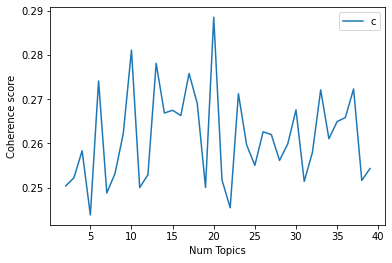

In [ ]:
# Show graph
limit = 40 
start = 2 
step = 1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()